Sumário:



1.   Instalação de bibliotecas
2.   Download de dados de S.R.
3.   Leitura dos dados de S.R.
4.   Visualização dos dados



In [1]:
!pip install geopandas cartopy pandas xarray scipy pyepsg xmltodict wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=8e78023934063faecc576875e270a807b042a0731692dd0ee92eb56a2b7b5dfc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# Required modules
import os, requests, wget, xmltodict
from datetime import datetime, timedelta
import cartopy.crs as ccrs

import xarray as xr      # Read / Write NetCDF4 files
import matplotlib.pyplot as plt  # Plotting library

## Criando uma pasta local no servidor deste Google Colab para salvar as informações

In [3]:
!mkdir -p Downloads

## Dados do Satélite GOES-16

### Características
  
  - Dados Públicos
  - Servidor: NOAA
  - Formato dos dados: NETCDF
  - Acesso: via URL
  - URL: formato XML
  - main URL: "https://noaa-goes16.s3.amazonaws.com"

In [4]:


r = requests.get("https://noaa-goes16.s3.amazonaws.com")

xmlPage = xmltodict.parse(r.content)

type(xmlPage)

print(xmlPage)


{'ListBucketResult': {'@xmlns': 'http://s3.amazonaws.com/doc/2006-03-01/', 'Name': 'noaa-goes16', 'Prefix': None, 'Marker': None, 'MaxKeys': '1000', 'IsTruncated': 'true', 'Contents': [{'Key': 'ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170671748180.nc', 'LastModified': '2018-05-22T18:04:38.000Z', 'ETag': '"4e033c8189f39772f4acd09469e4514b"', 'Size': '7644225', 'Owner': {'ID': '07cd0b2bd0f30623096b9275946be8ed8f210ec3ec83f15b416f8296c4e7e947', 'DisplayName': 'sandbox'}, 'StorageClass': 'INTELLIGENT_TIERING'}, {'Key': 'ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170691603180.nc', 'LastModified': '2018-05-22T18:03:53.000Z', 'ETag': '"8e248c9644a9cfa627b3d591b8f18f1f-2"', 'Size': '9952640', 'Owner': {'ID': '07cd0b2bd0f30623096b9275946be8ed8f210ec3ec83f15b416f8296c4e7e947', 'DisplayName': 'sandbox'}, 'StorageClass': 'INTELLIGENT_TIERING'}, {'Key': 'ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s200000

## Definindo algumas classes para gestão dos dados do GOES

In [5]:


class OwnerClass:
  def __init__(self, id:str, displayName: str):
    self.id = id
    self.displayName = displayName

class GOESContent:
  def __init__(self,
               key: str,
               lastModified: datetime,
               ETag: str,
               size: int,
               owner: OwnerClass,
               storageClass:str):

    self.urlFileName = key
    self.lastModified = lastModified
    self.ETag = ETag
    self.size = size
    self.owner = owner
    self.storageClass = storageClass

  def __str__(self):
    return f"url: {self.urlFileName}; lastModified: {self.lastModified}"

  def __repr__(self):
    return self.__str__()

  @classmethod
  def parseContent(cls,
                   Key: str,
                   LastModified: datetime,
                   ETag: str,
                   Size: int,
                   Owner: dict[str,str],
                   StorageClass:str):
    try:

      modifiedDate = datetime.fromisoformat(LastModified.replace("Z",""))
      owner = OwnerClass(Owner["ID"], Owner["DisplayName"])

      return GOESContent(Key, modifiedDate, ETag, Size, owner, StorageClass)

    except ValueError as err:
      print(f"Unable to convert {LastModified}")
      raise




class GOES_Data_Fetcher:
  def __init__(self, main_URL: str = "https://noaa-goes16.s3.amazonaws.com"):
    self.main_URL = main_URL

    self.mainURL_AsDict = self.read_mainURL()

    self.contents: list[GOESContent] = self.fetch_contents()

  def read_mainURL(self):
    r = requests.get("https://noaa-goes16.s3.amazonaws.com")

    xmlPage = xmltodict.parse(r.content)

    return xmlPage

  def fetch_contents(self):
    ListBucketResult = self.mainURL_AsDict['ListBucketResult']
    _contents: list[dict] = ListBucketResult["Contents"]

    contents = [GOESContent.parseContent(**content) for content in _contents]

    return contents

  def list_downloadable_files(self) -> GOESContent:

    for content in self.contents:
      yield content

class GoesDataManager:
  def __init__(self, goesDataFetcher:GOES_Data_Fetcher| None= None):
    if (goesDataFetcher is None):
      self.goesDataFetcher = GOES_Data_Fetcher()

    else:
      self.goesDataFetcher = goesDataFetcher

  def list_downloadable_files(self) -> GOESContent:

    return self.goesDataFetcher.list_downloadable_files()

  def filterDownlodable_files(self,
                              dateStart:datetime,
                              dateEnd:datetime|None) -> GOESContent:
    """Yields each downloadable Goes Content from the provided date-range"""

    if (dateEnd is None):
      dateEnd = datetime.now + timedelta(1, "days")

    filteringRule = lambda content: all([(content.lastModified >= dateStart),
                                         (content.lastModified < dateEnd)]
    )

    for content in self.list_downloadable_files():

      if filteringRule(content):
        yield content


  def download_filteredContent(self, contents: list[GOESContent], targetDirectory: str = "Downloads", verbose:bool = False) -> None:
    counter = 0
    totalFilesToDownload = len(contents)
    for content in contents:
      fullURL = os.path.join(self.goesDataFetcher.main_URL, content.urlFileName)

      wget.download(fullURL, out=targetDirectory)
      counter += 1

      if (verbose):
        print(f"{counter} out of {totalFilesToDownload} Files downloaded. Current download: {content} ")




goes_data_Fetcher = GoesDataManager()

In [6]:
counter = 0

contentGenerator = goes_data_Fetcher.filterDownlodable_files(datetime(2018,1,1), datetime(2018,6,1))

contentsfilteredContents: list[GOESContent] = [x for x in contentGenerator]

# contentsfilteredContents[:5]

print("n° de arquivos para download: ", len(contentsfilteredContents))



n° de arquivos para download:  986


In [7]:
# downloading only the first N files

N_files = 20
goes_data_Fetcher.download_filteredContent(contentsfilteredContents[:N_files], verbose=True)

1 out of 20 Files downloaded. Current download: url: ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170671748180.nc; lastModified: 2018-05-22 18:04:38 
2 out of 20 Files downloaded. Current download: url: ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170691603180.nc; lastModified: 2018-05-22 18:03:53 
3 out of 20 Files downloaded. Current download: url: ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170751219598.nc; lastModified: 2018-05-22 18:04:31 
4 out of 20 Files downloaded. Current download: url: ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170752149454.nc; lastModified: 2018-05-22 18:07:04 
5 out of 20 Files downloaded. Current download: url: ABI-L1b-RadC/2000/001/12/OR_ABI-L1b-RadC-M3C01_G16_s20000011200000_e20000011200000_c20170752204183.nc; lastModified: 2018-05-22 18:03:56 
6 out of 20 Files downloaded. Current downloa

In [38]:
from glob import glob

cwd = os.path.join(os.getcwd(), "Downloads")
filesToDownload = glob(cwd + "/*OR_ABI*.nc")

filesToDownload

file = xr.open_mfdataset(filesToDownload, concat_dim="time", combine='nested')




In [39]:
file

<xarray.Dataset>
Dimensions:                                 (time: 20, y: 3000, x: 5000,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             band: 1, num_star_looks: 24)
Coordinates:
    t                                       datetime64[ns] 2000-01-01T11:43:21
  * y                                       (y) float64 0.1265 ... 0.04257
  * x                                       (x) float64 -0.07503 ... 0.06495
    y_image                                 float32 0.08456
    x_image                                 float32 -0.00504
    band_id                                 (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength                         (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    t_star_look                             (num_star_looks) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
    band_wavelength_star_look               (num_star_looks) float32 dask.array<chunksize=(24,), meta=np.ndarray>
Dimensions without coordinates: time, number_of_time_bounds,
                                number_of_image_bounds, band, num_star_looks
Data variables: (12/31)
    Rad                                     (time, y, x) float32 dask.array<chunksize=(1, 3000, 5000), meta=np.ndarray>
    DQF                                     (time, y, x) float32 dask.array<chunksize=(1, 3000, 5000), meta=np.ndarray>
    time_bounds                             (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                  (time) int32 -2147483647 ... -214...
    y_image_bounds                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                          (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...                                      ...
    percent_uncorrectable_L0_errors         (time) float32 nan nan ... nan nan
    earth_sun_distance_anomaly_in_AU        (time) float32 0.9949 ... 0.9948
    algorithm_dynamic_input_data_container  (time) int32 -2147483647 ... -214...
    processing_parm_version_container       (time) int32 -2147483647 ... -214...
    algorithm_product_version_container     (time) int32 -2147483647 ... -214...
    star_id                                 (time, num_star_looks) float32 dask.array<chunksize=(1, 24), meta=np.ndarray>
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    production_data_source:    n/a
    timeline_id:               ABI Mode 3
    date_created:              2017-03-16T21:49:45.4Z
    time_coverage_start:       2000-01-01T12:00:00.0Z
    time_coverage_end:         2000-01-01T12:00:00.0Z
    id:                        1d1658f4-0bd2-454f-aced-a8da8cbe5742

In [49]:
fileFiltered = file['Rad'].sel({"y":file['y'][::10],
                                "x":file['x'][::10]})

fileFiltered


<xarray.DataArray 'Rad' (time: 20, y: 300, x: 500)>
dask.array<getitem, shape=(20, 300, 500), dtype=float32, chunksize=(1, 300, 500), chunktype=numpy.ndarray>
Coordinates:
    t        datetime64[ns] 2000-01-01T11:43:21
  * y        (y) float64 0.1265 0.1263 0.126 0.1257 ... 0.04339 0.04311 0.04283
  * x        (x) float64 -0.07503 -0.07475 -0.07447 ... 0.06413 0.06441 0.06469
    y_image  float32 0.08456
    x_image  float32 -0.00504
Dimensions without coordinates: time
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
    units:                  W m-2 sr-1 um-1
    resolution:             y: 0.000028 rad x: 0.000028 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF

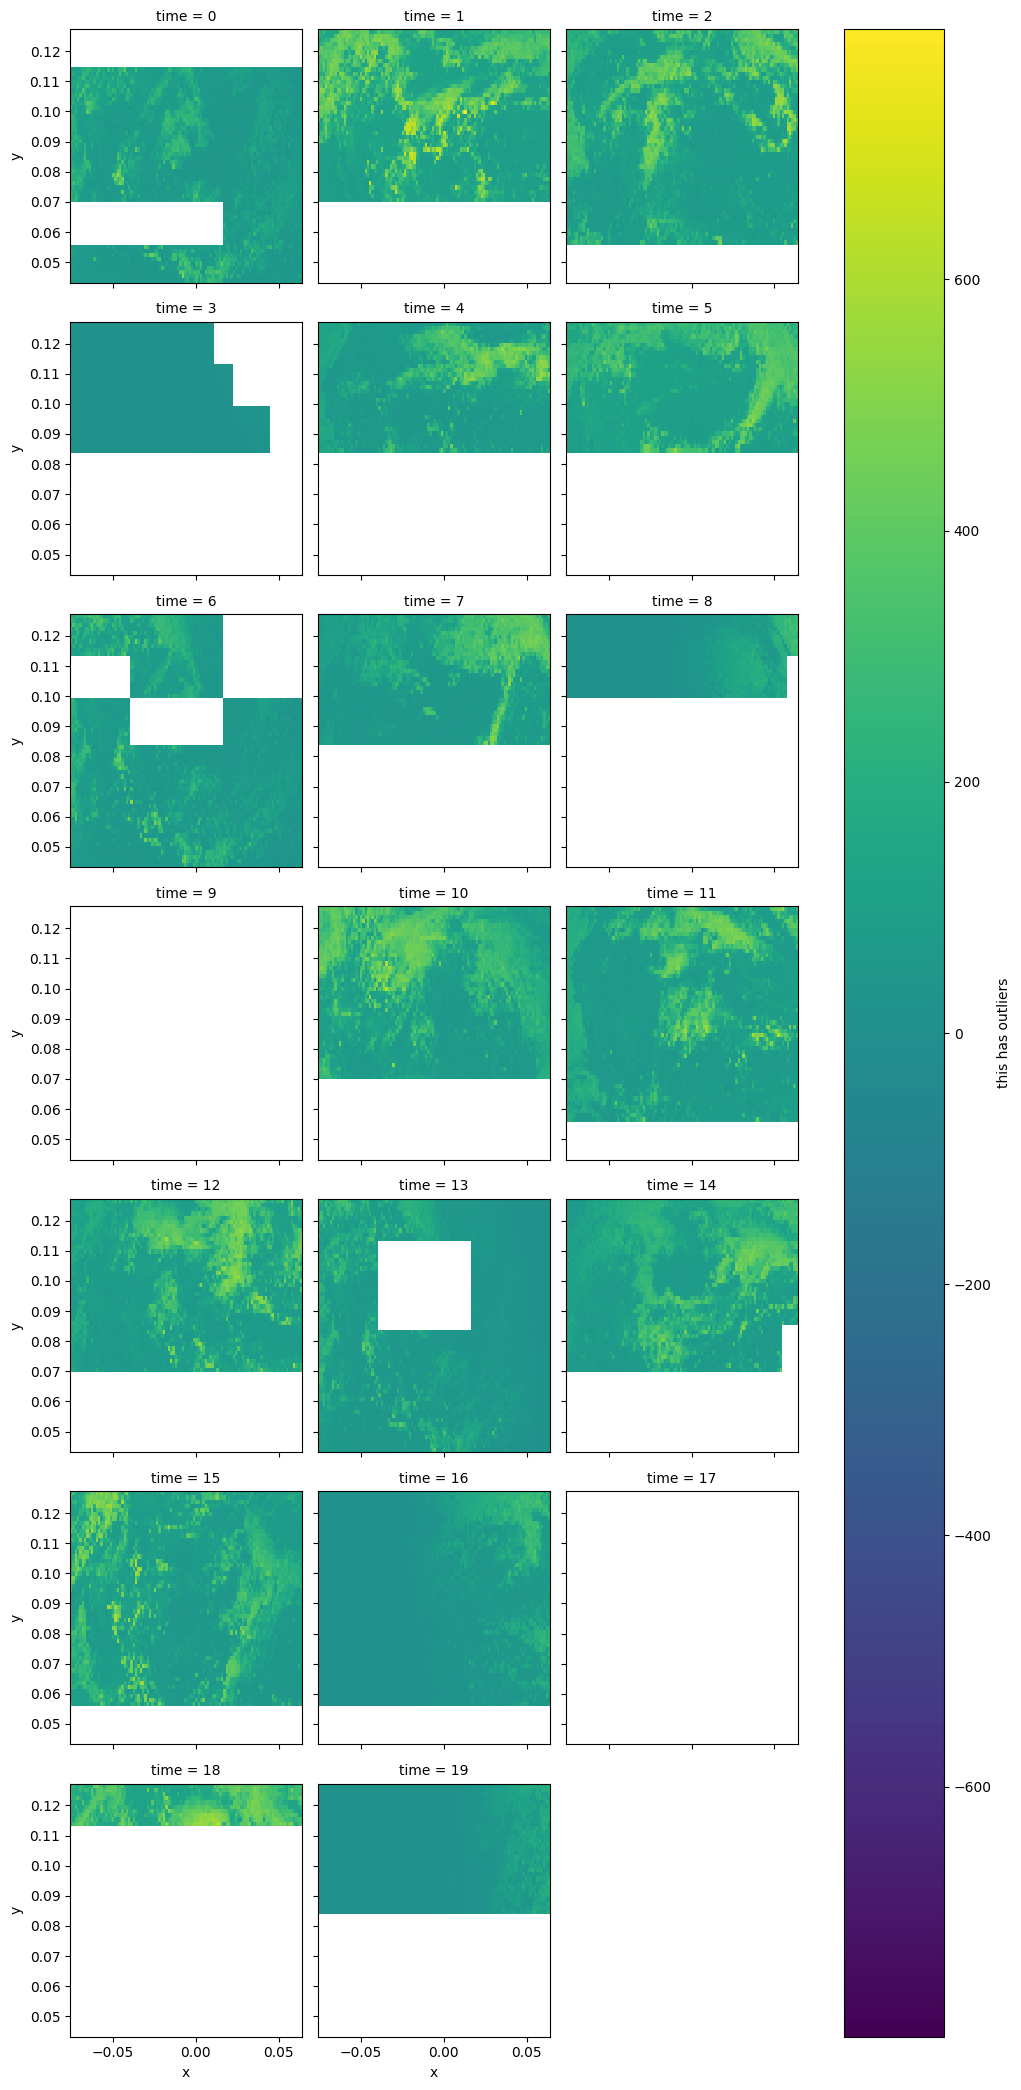

In [48]:
# Plot the image
gridAxes = fileFiltered.plot(x="x",
                             y="y",
                             cmap='viridis',
                             col="time",
                             col_wrap=3,
                             cbar_kwargs={"label": "this has outliers"})

#-----------------------------------------------------------------------------------------------------------

# Show the image
plt.show()

<class 'cartopy.mpl.geoaxes.GeoAxes'>


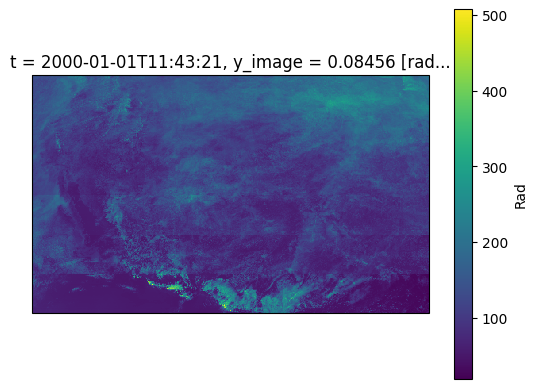

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()})

(
file['Rad'].sel({"y":file['y'][::10],
                 "x":file['x'][::10]})
                .mean("time")
                .plot(x="x",
                      y="y",
                      cmap="viridis",
                      ax=ax,
                      transform=ccrs.PlateCarree())

)

ax.coastlines("110m")

print(type(ax))

#-----------------------------------------------------------------------------------------------------------

# Show the image
plt.show()